In [13]:
from mimic.utilities import *

from mimic.model_infer.infer_gLV_bayes import *
from mimic.model_infer import *
from mimic.model_simulate import *
from mimic.model_simulate.sim_gLV import *


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Used Bayesian inference to infer the parameters of a (linearised) gLV model

The generalized Lotka-Volterra equation takes the form

$$ \frac{dX_i}{dt} = \mu_i X_i + X_i M_{ij} X_j + X_i \epsilon_{il} u_l $$

where:
-   $X_i$ is the concentration of a species
-   $\mu_i$ is its specific growth rate
-   $M_{ij}$ is the effect of the interaction of species $i$ on species $j$
-   $\epsilon_{il}$ is the susceptibility to the time-dependent perturbation $u_l$

### Five species, single time course

(5,)
Model parameters:
Model: gLV
num_species: 5
mu: [1.28 0.56 2.07 0.86 0.7 ]
M: [[-0.05  0.   -0.03  0.    0.  ]
 [ 0.   -0.1   0.    0.05  0.  ]
 [ 0.    0.   -0.15  0.    0.  ]
 [ 0.    0.    0.   -0.01  0.  ]
 [ 0.02  0.    0.    0.   -0.2 ]]
epsilon: []
Using the following parameters for gLV simulation: {'num_species': 5, 'mu': array([1.27853844, 0.55683415, 2.06752757, 0.86387608, 0.70448068]), 'M': array([[-0.05 ,  0.   , -0.025,  0.   ,  0.   ],
       [ 0.   , -0.1  ,  0.   ,  0.05 ,  0.   ],
       [ 0.   ,  0.   , -0.15 ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , -0.01 ,  0.   ],
       [ 0.02 ,  0.   ,  0.   ,  0.   , -0.2  ]]), 'epsilon': array([], shape=(5, 0), dtype=float64)}


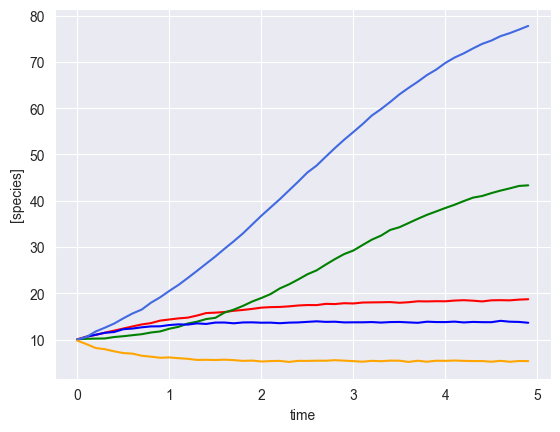

In [14]:
# In this example n >> p and it is basically same as standard regression
# We have to be careful as most of these gLV models are very weakly identifiable

set_all_seeds(1234)

# SETUP MODEL
# establish size of model
num_species = 5

# construct interaction matrix
# TODO do this programmatically
M = np.zeros((num_species, num_species))
np.fill_diagonal(M, [-0.05, -0.1, -0.15, -0.01, -0.2])
M[0, 2] = -0.025
M[1, 3] = 0.05
M[4, 0] = 0.02

# construct growth rates matrix
mu = np.random.lognormal(0.01, 0.5, num_species)
print(mu.shape)

# instantiate simulator
simulator = sim_gLV(num_species=num_species,
                    M=M,
                    mu=mu)
simulator.print_parameters()

# PRODUCE SIMULATED RESULTS
# initial conditions
init_species = 10 * np.ones(num_species)

times = np.arange(0, 5, 0.1)
yobs, init_species, mu, M, _  = simulator.simulate(times=times, init_species=init_species)

# add some gaussian noise
yobs = yobs + np.random.normal(loc=0, scale=0.1, size=yobs.shape)

# plot simulation
plot_gLV(yobs, times)

### Bayesian inference (no shrinkage)
First we will do Bayesian inference without any shrinkage priors

In [15]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as at
import pickle
import cloudpickle


In [16]:
X, F = linearize_time_course_16S(yobs, times)
print(X.shape)
print(F.shape)

print(F[:10,:])


(49, 6)
(49, 5)
[[ 0.52895036  0.08536993  0.68020563  0.56929112 -0.80133732]
 [ 0.36152371  0.04655615  0.38556959  1.05386249 -0.96717332]
 [ 0.41594142  0.03248581  0.37166766  0.67425061 -0.3271869 ]
 [ 0.37814123  0.29460925  0.14918686  0.67619656 -0.59925564]
 [ 0.37527599  0.1640331   0.50946111  0.80951352 -0.50752239]
 [ 0.36122979  0.2060925   0.11214721  0.69562975 -0.18823973]
 [ 0.32668768  0.19299652  0.21482467  0.52364284 -0.66624361]
 [ 0.21463664  0.3216537   0.15238115  0.85808323 -0.30829425]
 [ 0.388769    0.19969247  0.01714542  0.63129112 -0.3851611 ]
 [ 0.17175939  0.48660706  0.20994262  0.69867514  0.11979933]]


In [17]:
# Set priors
mu_prior = [1.28, 0.56, 2.07, 0.86, 0.7] 
M_prior = 0.1

X shape: (49, 6)
F shape: (49, 5)
Number of species: 5
Manually determined mu prior
Manually determined M prior


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu_hat, M_ii_hat_p, M_ij_hat]


Output()

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 49 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


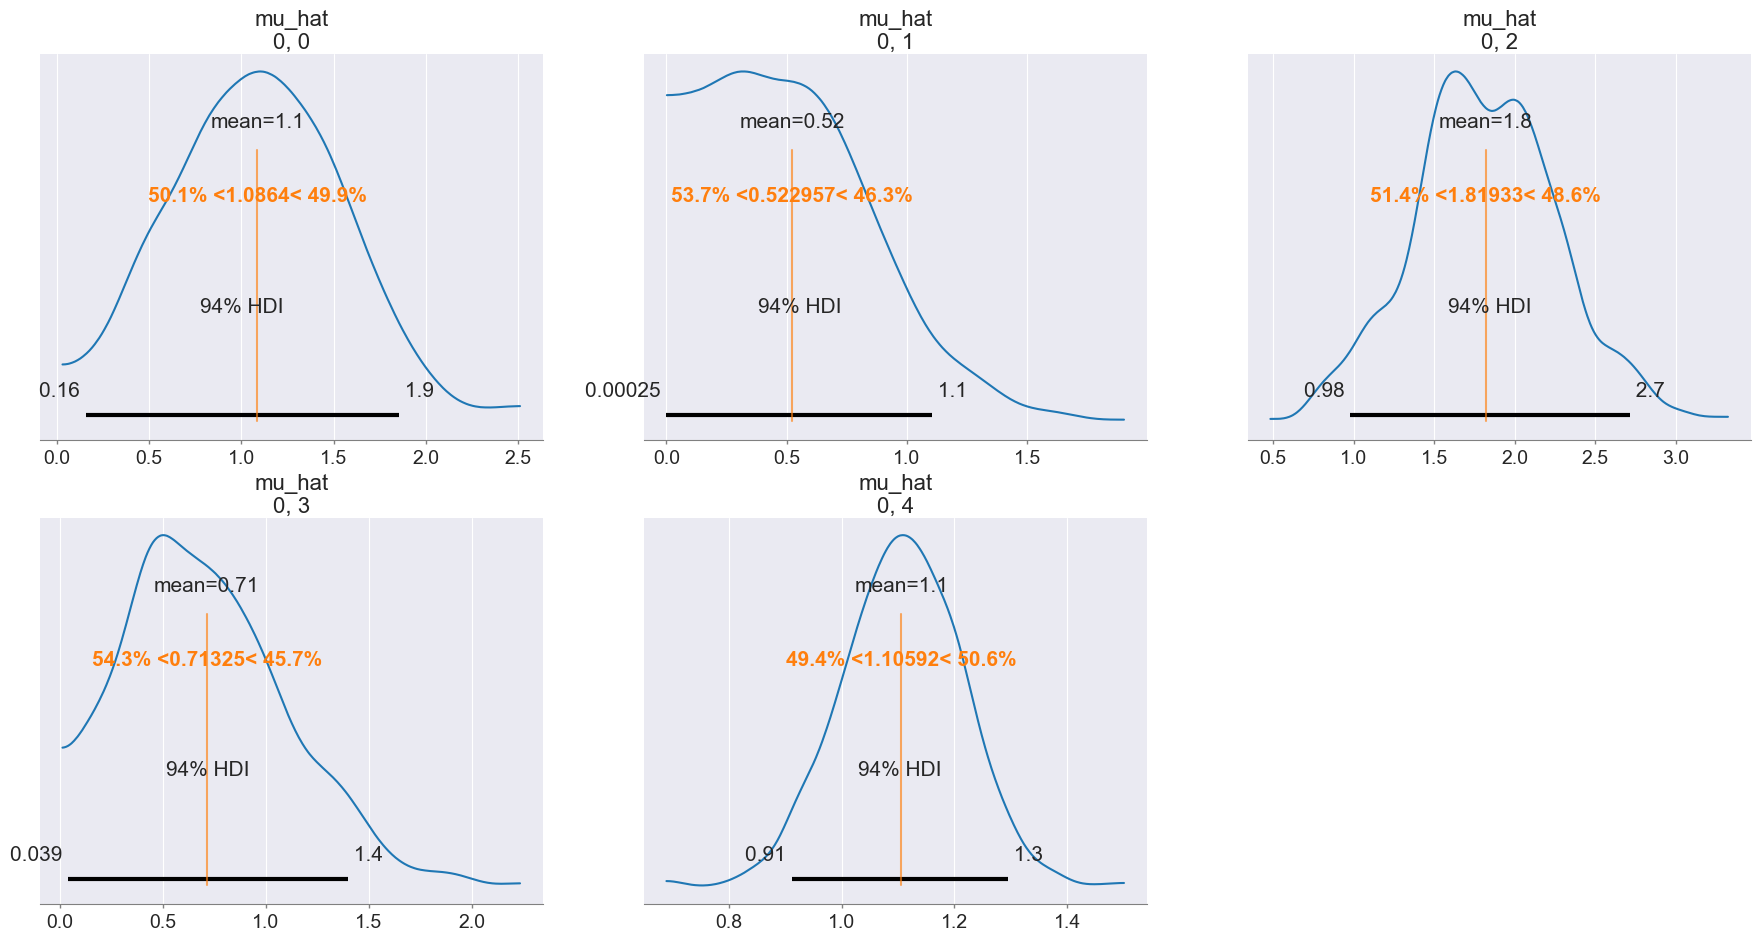

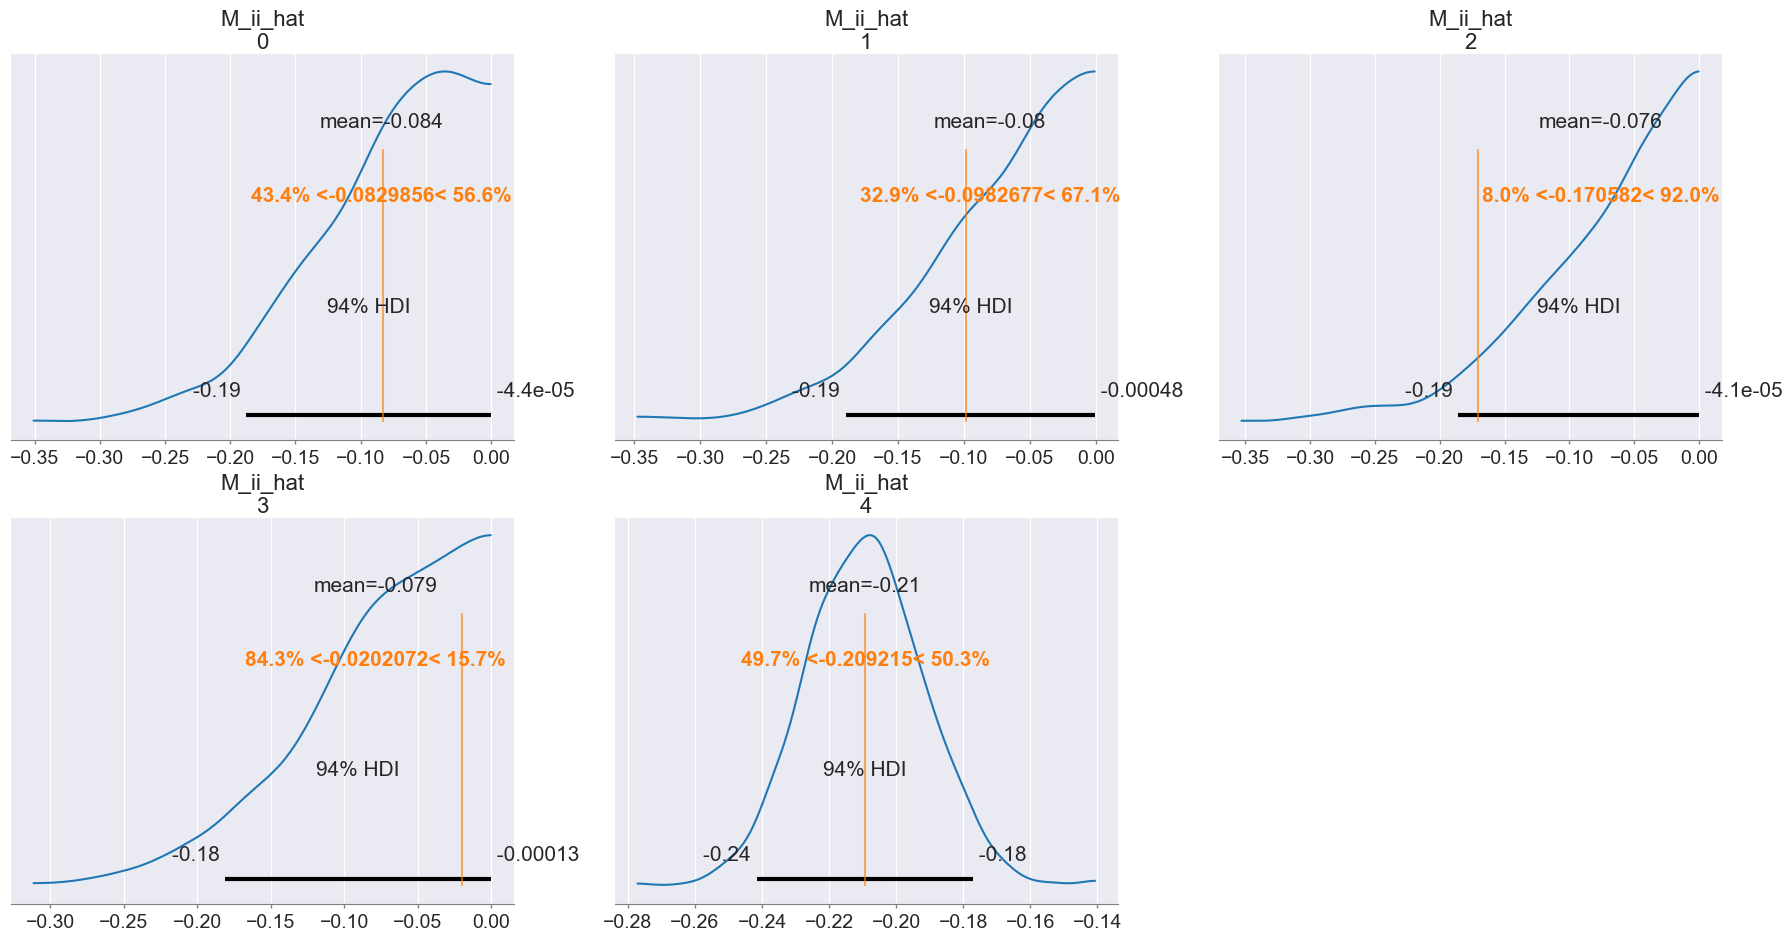

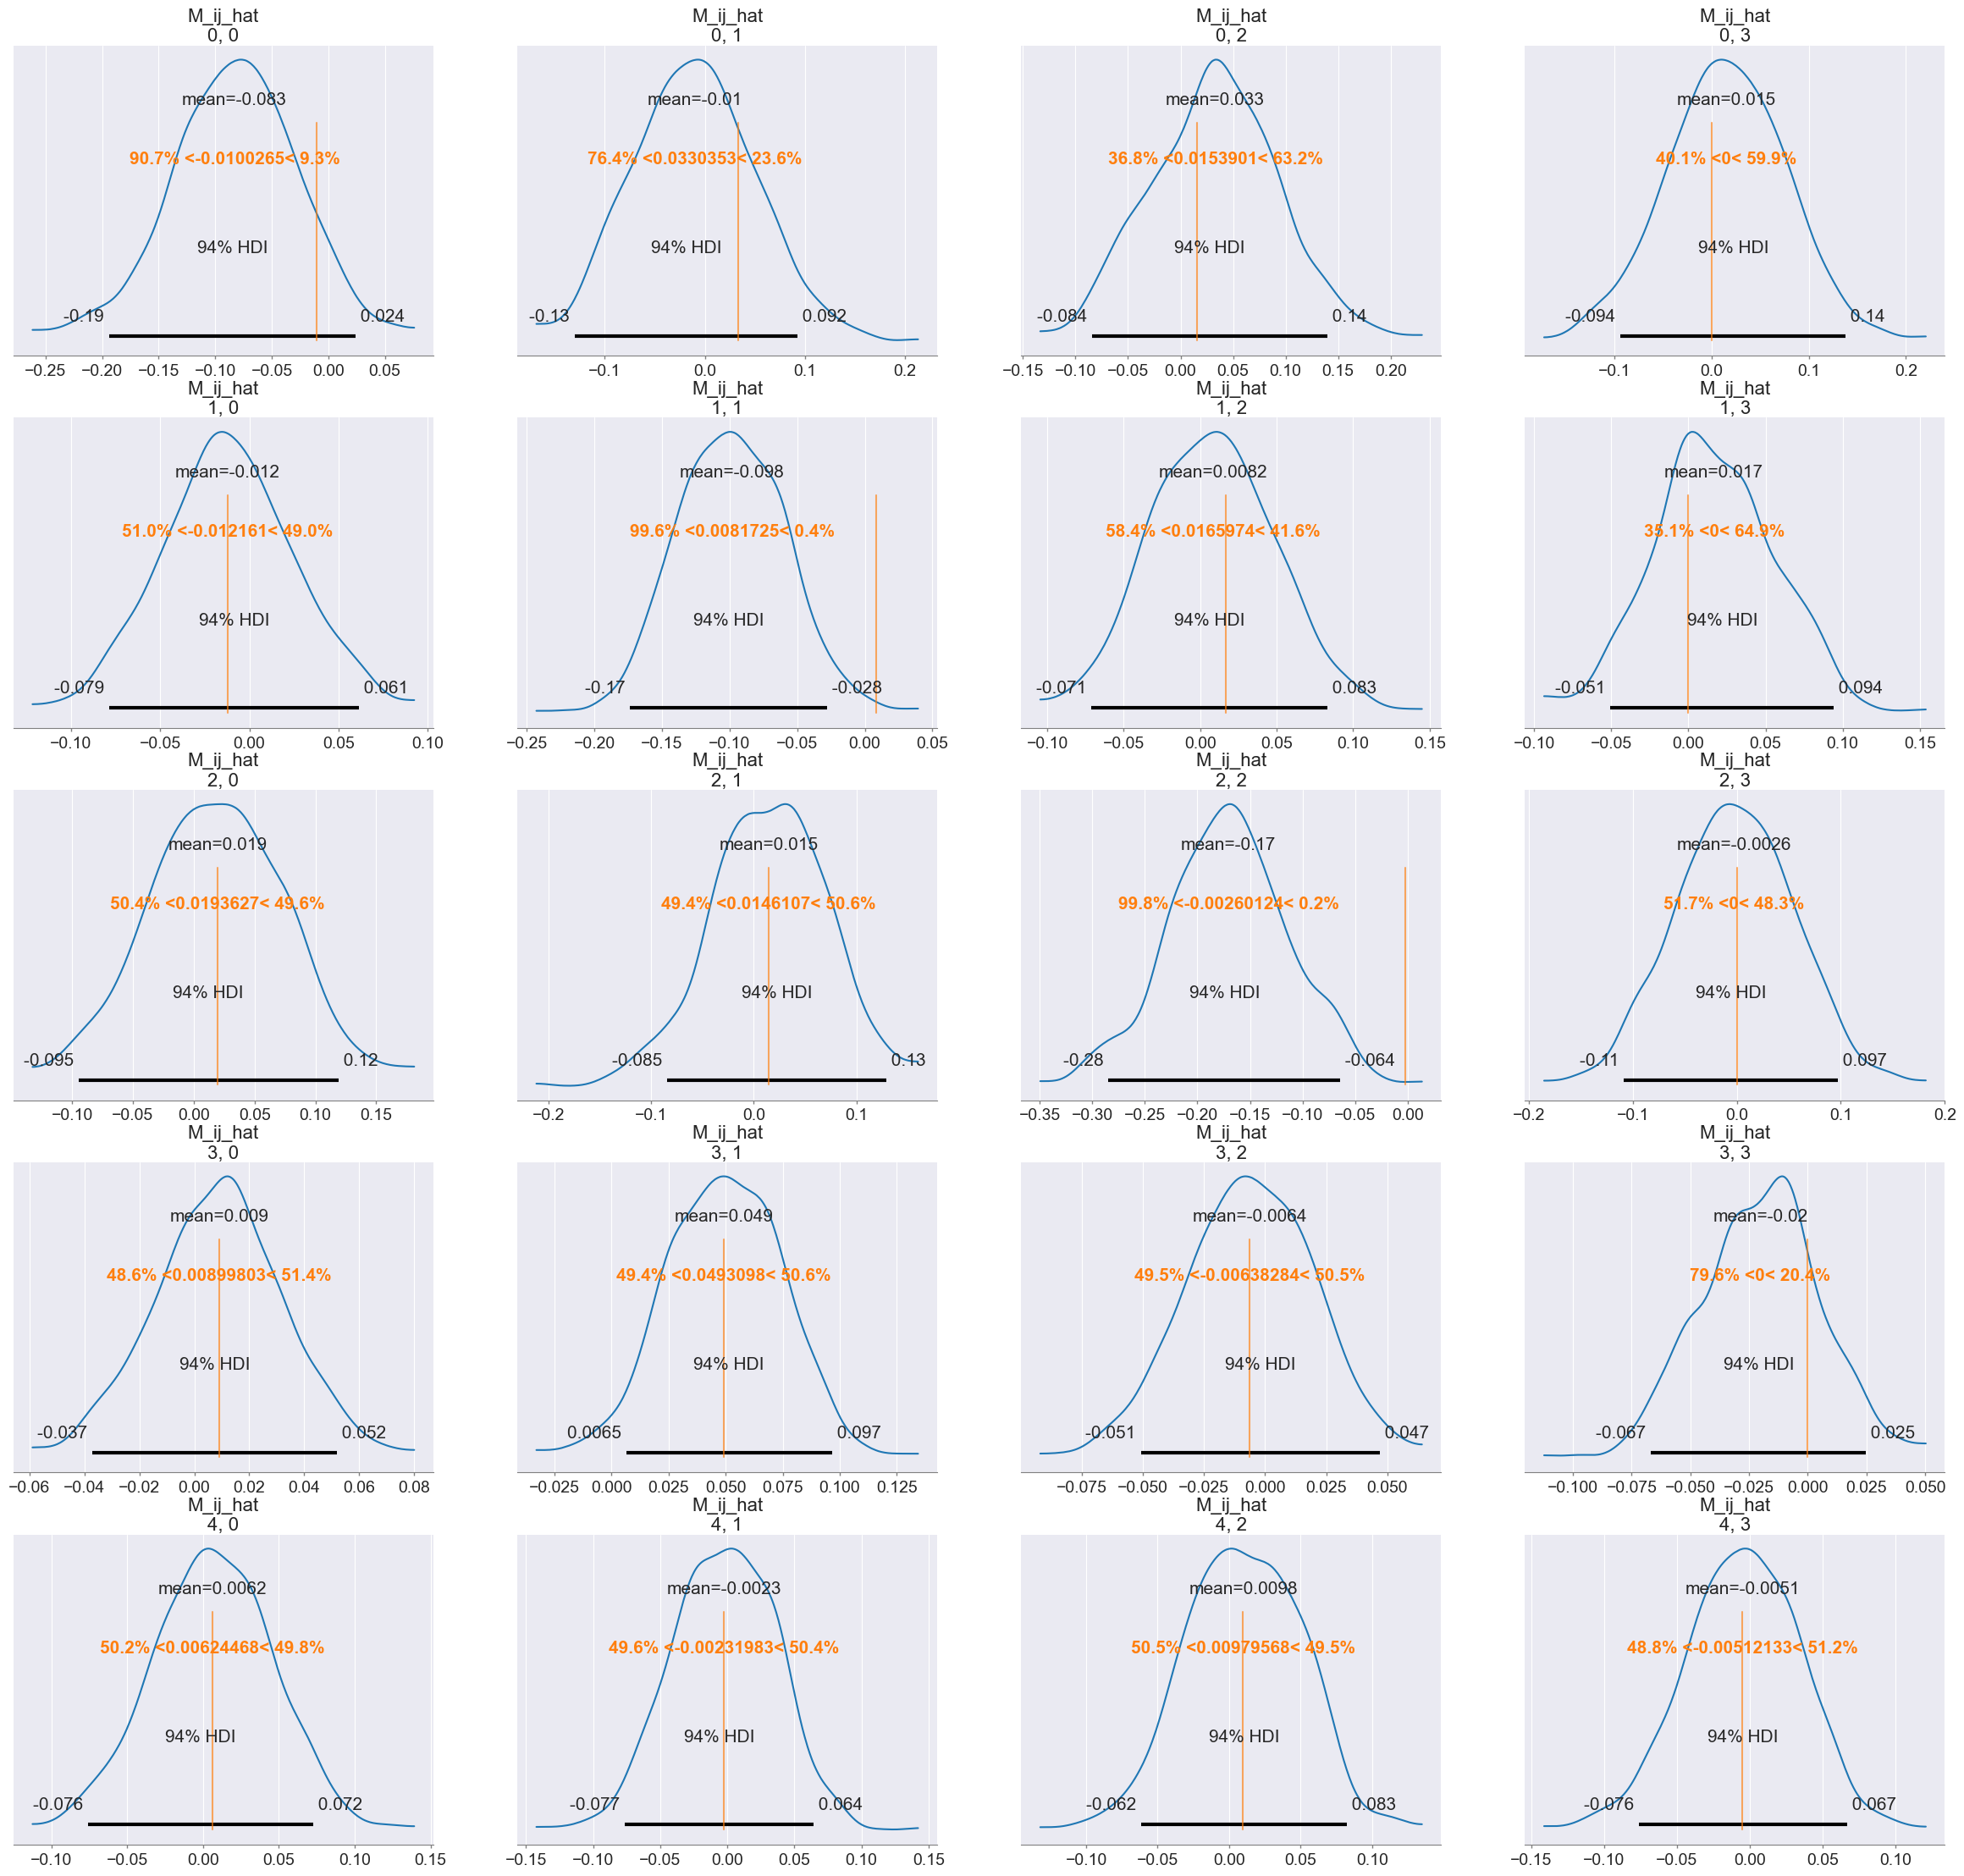

In [18]:
# Perform Bayesian inference

inference = infergLVbayes(X, F, mu_prior, M_prior)
idata = inference.run_bayes_gLV()

In [ ]:
print(var_names)

In [20]:
# Print summary

summary = az.summary(idata, var_names=["mu_hat", "M_ii_hat", "M_ij_hat", "M_hat", "sigma"])
print(summary[["mean", "sd", "r_hat"]])


# Save posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')



/Users/chaniaclare/anaconda3/bin/python3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chaniaclare/anaconda3/bin/python3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chaniaclare/anaconda3/bin/python3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chaniaclare/anaconda3/bin/python3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


                 mean     sd  r_hat
mu_hat[0, 0]    1.086  0.460   1.00
mu_hat[0, 1]    0.523  0.340   1.00
mu_hat[0, 2]    1.819  0.450   1.00
mu_hat[0, 3]    0.713  0.389   1.00
mu_hat[0, 4]    1.106  0.106   1.00
M_ii_hat[0]    -0.084  0.060   1.00
M_ii_hat[1]    -0.080  0.062   1.00
M_ii_hat[2]    -0.076  0.062   1.00
M_ii_hat[3]    -0.079  0.058   1.01
M_ii_hat[4]    -0.209  0.018   1.00
M_ij_hat[0, 0] -0.083  0.057   1.00
M_ij_hat[0, 1] -0.010  0.061   1.00
M_ij_hat[0, 2]  0.033  0.061   1.00
M_ij_hat[0, 3]  0.015  0.062   1.00
M_ij_hat[1, 0] -0.012  0.037   1.00
M_ij_hat[1, 1] -0.098  0.040   1.00
M_ij_hat[1, 2]  0.008  0.041   1.00
M_ij_hat[1, 3]  0.017  0.040   1.00
M_ij_hat[2, 0]  0.019  0.057   1.00
M_ij_hat[2, 1]  0.015  0.056   1.00
M_ij_hat[2, 2] -0.171  0.058   1.00
M_ij_hat[2, 3] -0.003  0.058   1.00
M_ij_hat[3, 0]  0.009  0.024   1.00
M_ij_hat[3, 1]  0.049  0.025   1.00
M_ij_hat[3, 2] -0.006  0.026   1.00
M_ij_hat[3, 3] -0.020  0.025   1.00
M_ij_hat[4, 0]  0.006  0.040

'model_posterior.nc'

(2, 500, 5, 5)
(2, 500, 1, 5)
Using the following parameters for gLV simulation: {'num_species': 5, 'mu': array([1.0856529 , 0.49262155, 1.80077418, 0.67020054, 1.10671558]), 'M': array([[-0.08058701, -0.0104756 ,  0.0338252 ,  0.01421169,  0.        ],
       [-0.01352798, -0.09852129,  0.00836007,  0.01519999,  0.        ],
       [ 0.01855493,  0.01559635, -0.17025536, -0.00255011,  0.        ],
       [ 0.00971026,  0.04972949, -0.00594028, -0.01931559,  0.        ],
       [ 0.00590253, -0.00154155,  0.00939058, -0.00445606, -0.20916343]]), 'epsilon': array([], shape=(5, 0), dtype=float64)}
mu_hat/mu:
[1.0856529  0.49262155 1.80077418 0.67020054 1.10671558]
[1.27853844 0.55683415 2.06752757 0.86387608 0.70448068]

M_hat/M:
[[-0.08 -0.01  0.03  0.01  0.  ]
 [-0.01 -0.1   0.01  0.02  0.  ]
 [ 0.02  0.02 -0.17 -0.    0.  ]
 [ 0.01  0.05 -0.01 -0.02  0.  ]
 [ 0.01 -0.    0.01 -0.   -0.21]]

 [[-0.05   0.    -0.025  0.     0.   ]
 [ 0.    -0.1    0.     0.05   0.   ]
 [ 0.     0.    -0

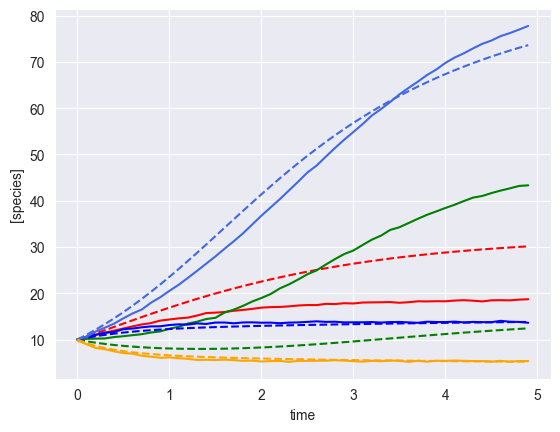

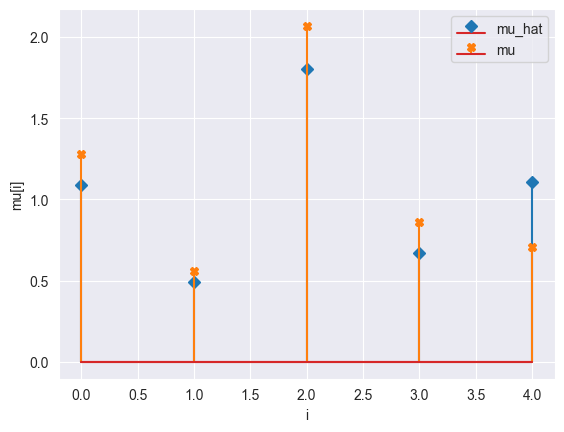

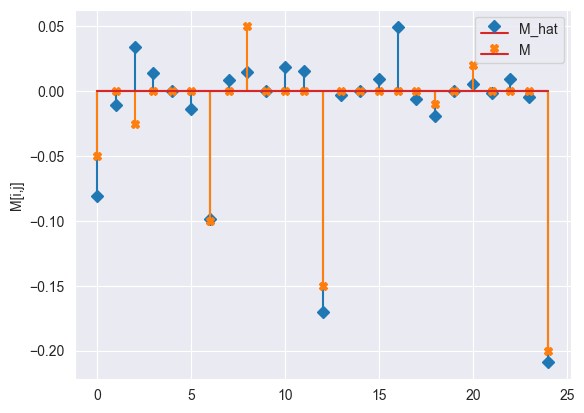

In [21]:
# 4 chains x 100 draws x 5 x 5 species
print( idata.posterior["M_hat"].values.shape )

print( idata.posterior["mu_hat"].values.shape )

# # get median posterior values   
M_h = np.median(idata.posterior["M_hat"].values, axis=(0,1))

mu_h = np.median(idata.posterior["mu_hat"].values, axis=(0, 1))
mu_h = mu_h.flatten()

predictor = sim_gLV(num_species=num_species,
                    M=M_h,
                    mu=mu_h
                 )
yobs_h, _, _, _, _ = predictor.simulate(times=times, init_species=init_species)

plot_fit_gLV(yobs, yobs_h, times)
compare_params(mu=(mu, mu_h), M=(M, M_h) )


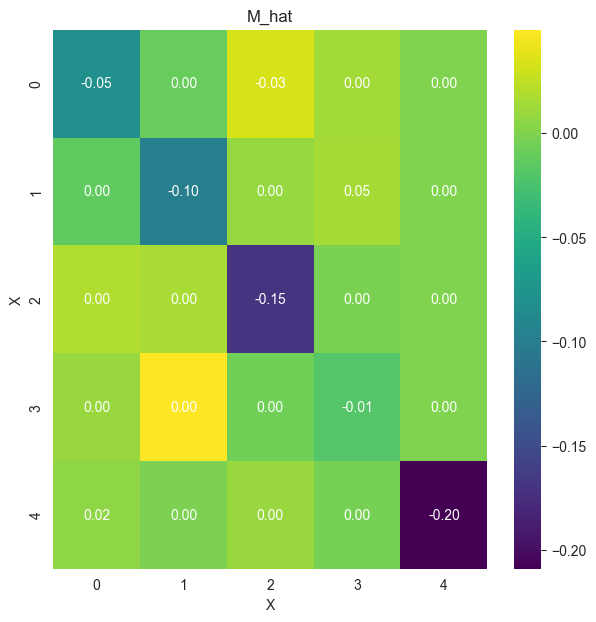

In [22]:
#plot_interaction_matrix(M_h)

infer_h = infergLVbayes(M_h)
matrix = infer_h.plot_interaction_matrix(M = M, M_h =M_h)


### Bayesian inference with shrinkage
Now we will do inference with the Horseshoe prior

In [ ]:
nX = num_species
n_obs = times.shape[0] - 1
noise_stddev = 0.1

# Params for shrinkage on M_ij (non diagonal elements)
DA = nX*nX - nX
DA0 = 3     # expected number of non zero entries in M_ij
N = n_obs - 2

In [ ]:
inference = infergLVbayes(X, F, mu, M, DA=DA, DA0=DA0, N=N, noise_stddev=noise_stddev)
idata, var_names = inference.run_bayes_gLV_shrinkage()

In [ ]:
print(var_names)

In [ ]:
# print summary
summary = az.summary(idata, var_names=var_names)
print(summary[["mean", "sd", "r_hat"]])

# Write posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')

In [ ]:
# get posterior medians
M_h = np.median(idata.posterior["M_hat"].values, axis=(0,1))

mu_h = np.median(idata.posterior["mu_hat"].values, axis=(0, 1))
mu_h = mu_h.flatten()

# compare median posterior values to true values
compare_params(mu=(mu, mu_h), M=(M, M_h) )


#plot_interaction_matrix(M_h)

infer_h = infergLVbayes(M_h)
matrix = infer_h.plot_interaction_matrix(M = M, M_h =M_h)


# Assess fit
predictor = sim_gLV(num_species=num_species,
                    M=M_h,
                    mu=mu_h
                 )
yobs_h, _, _, _, _ = predictor.simulate(times=times, init_species=init_species)
plot_fit_gLV(yobs, yobs_h, times)

### Bayesian inference with shrinkage and a perturbation with unknown interactions
Now we will do inference with the Horseshoe prior for shrinkage but now we include a perturbation (assuming unknown interaction terms). This gives more identifiability

perturbation:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0]
Model parameters:
Model: gLV
num_species: 5
mu: [1.28 0.56 2.07 0.86 0.7 ]
M: [[-0.05  0.   -0.03  0.    0.  ]
 [ 0.   -0.1   0.    0.05  0.  ]
 [ 0.    0.   -0.15  0.    0.  ]
 [ 0.    0.    0.   -0.01  0.  ]
 [ 0.02  0.    0.    0.   -0.2 ]]
epsilon: [[ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]]
Using the following parameters for gLV simulation: {'num_species': 5, 'mu': array([1.27853844, 0.55683415, 2.06752757, 0.86387608, 0.70448068]), 'M': array([[-0.05 ,  0.   , -0.025,  0.   ,  0.   ],
       [ 0.   , -0.1  ,  0.   ,  0.05 ,  0.   ],
       [ 0.   ,  0.   , -0.15 ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , -0.01 ,  0.   ],
       [ 0.02 ,  0.   ,  0.   ,  0.   , -0.2  ]]), 'epsilon': array([[ 1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.]])}


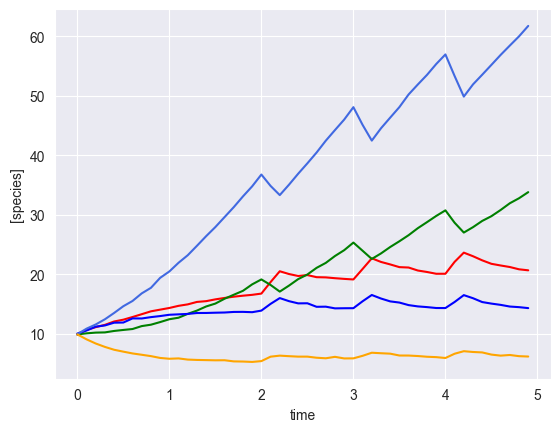

In [5]:
# use all previous definitions of mu, M etc

# construct perturbation matrix
num_perturbations = 1
epsilon = np.zeros([num_species, num_perturbations])
epsilon[:, 0] = [1, -1, 1, -1, 1]

def pert_fn(t):
    if 2.0 <= t < 2.2 or 3.0 <= t < 3.2 or 4.0 <= t < 4.2:
        return np.array([1])
    else: 
        return np.array([0])

# relinearise
u = np.array([pert_fn(t)[0] for t in times])
u = u.astype(int)
print('perturbation:\n', u)

X, F = linearize_time_course_16S_u(yobs, times, u)

# instantiate simulator
simulator = sim_gLV(num_species=num_species,
                    num_perturbations=num_perturbations,
                    M=M,
                    mu=mu,
                    epsilon=epsilon)
simulator.print_parameters()

yobs, init_species, mu, M, _  = simulator.simulate(times=times, init_species=init_species, u=pert_fn)

# add some gaussian noise
yobs = yobs + np.random.normal(loc=0, scale=0.1, size=yobs.shape)

# plot simulation
plot_gLV(yobs, times)

In [6]:
nX = num_species
n_obs = times.shape[0] - 1
noise_stddev = 0.1

# Params for shrinkage on M_ij (non diagonal elements)
DA = nX*nX - nX
DA0 = 3     # expected number of non zero entries in M_ij
N = n_obs - 2

DA: 20, DA0: 3, N: 47, noise_stddev: 0.1
Manually determined mu used
Manually determined M used


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon_hat, sigma, mu_hat, c2, tau, lam, M_0_0_hat_prior, M_0_1_hat_prior, M_0_2_hat_prior, M_0_3_hat_prior, M_0_4_hat_prior, M_1_0_hat_prior, M_1_1_hat_prior, M_1_2_hat_prior, M_1_3_hat_prior, M_1_4_hat_prior, M_2_0_hat_prior, M_2_1_hat_prior, M_2_2_hat_prior, M_2_3_hat_prior, M_2_4_hat_prior, M_3_0_hat_prior, M_3_1_hat_prior, M_3_2_hat_prior, M_3_3_hat_prior, M_3_4_hat_prior, M_4_0_hat_prior, M_4_1_hat_prior, M_4_2_hat_prior, M_4_3_hat_prior, M_4_4_hat_prior]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 207 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.


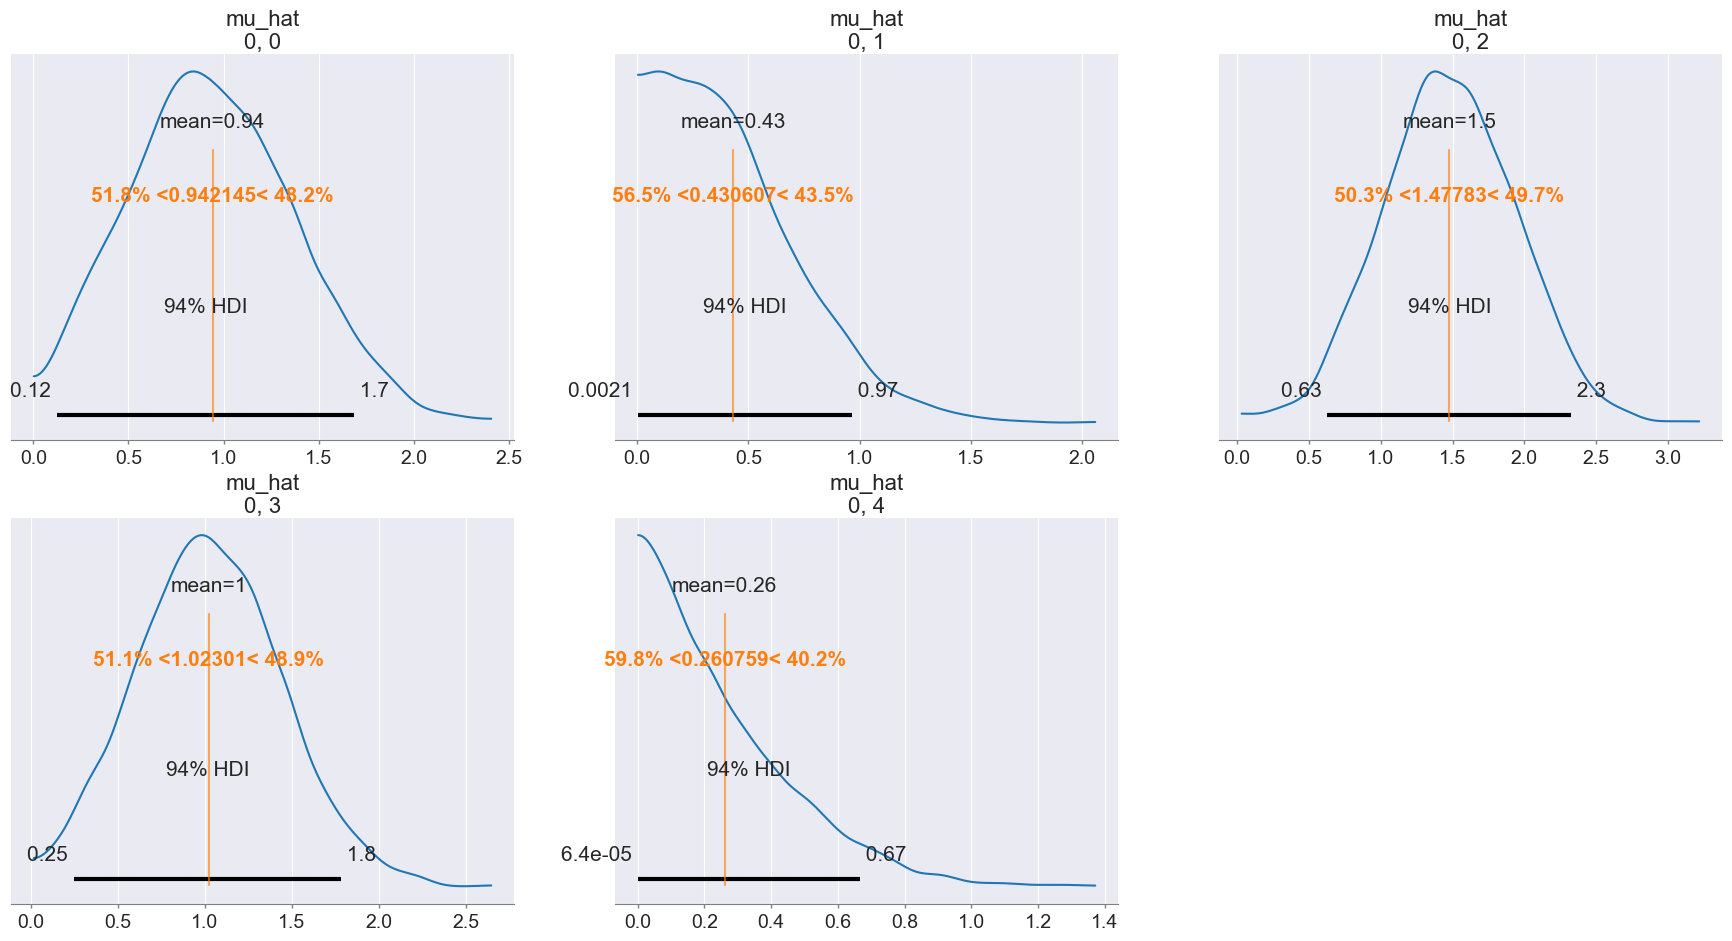

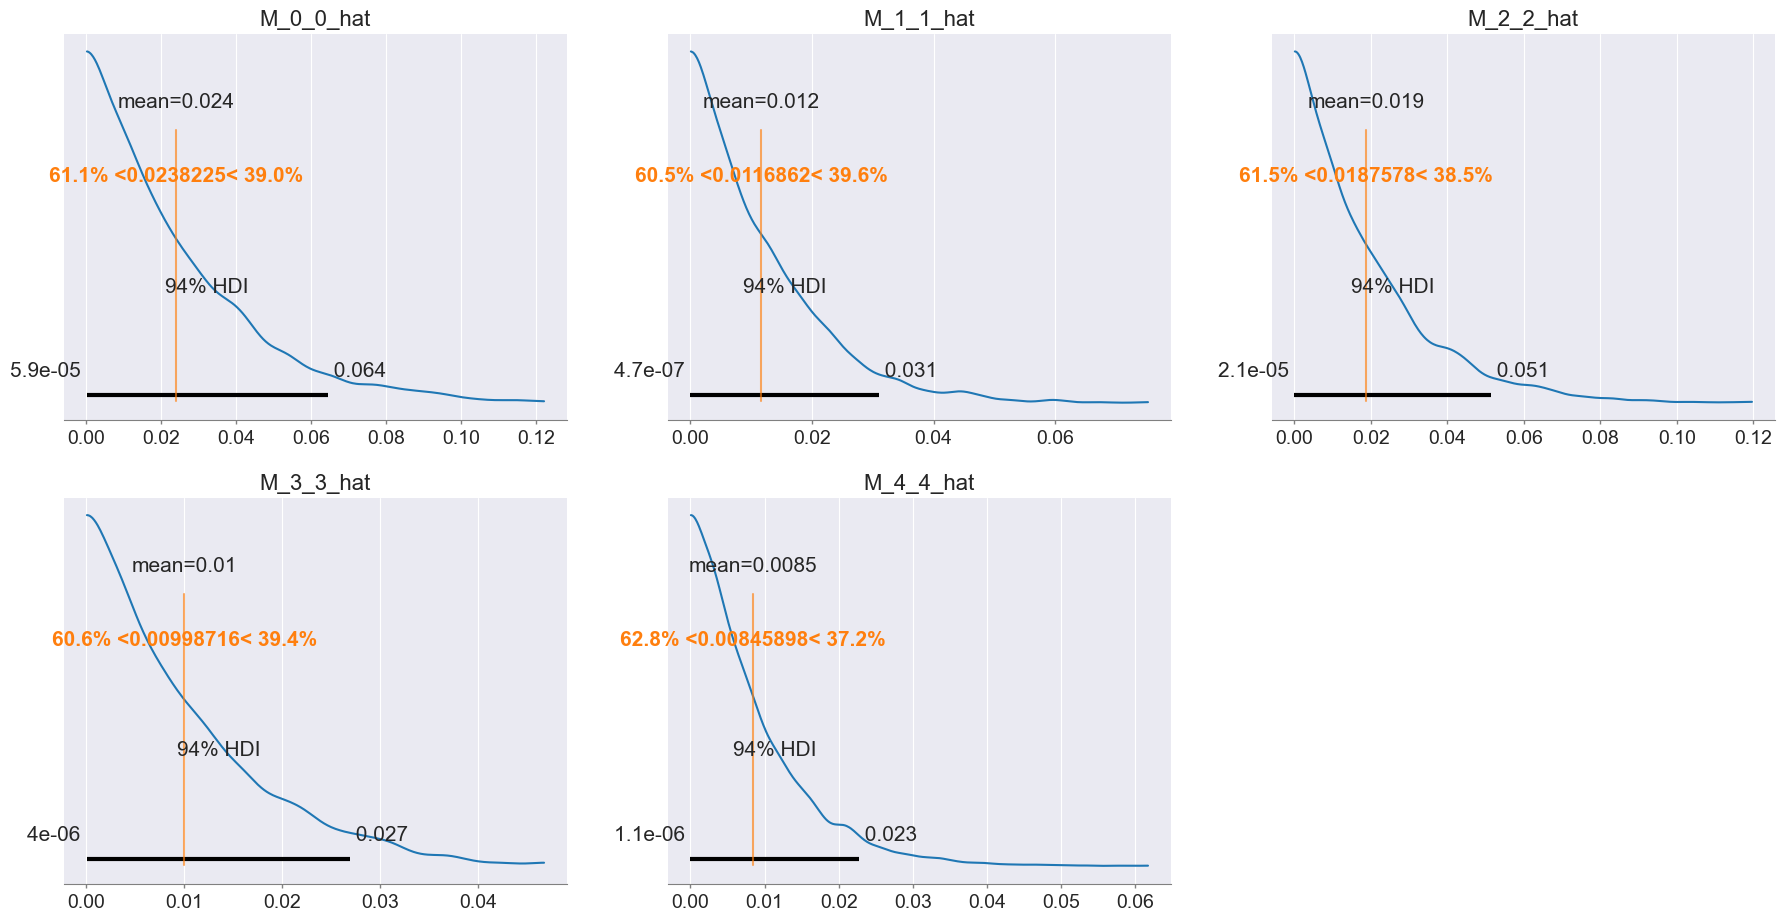

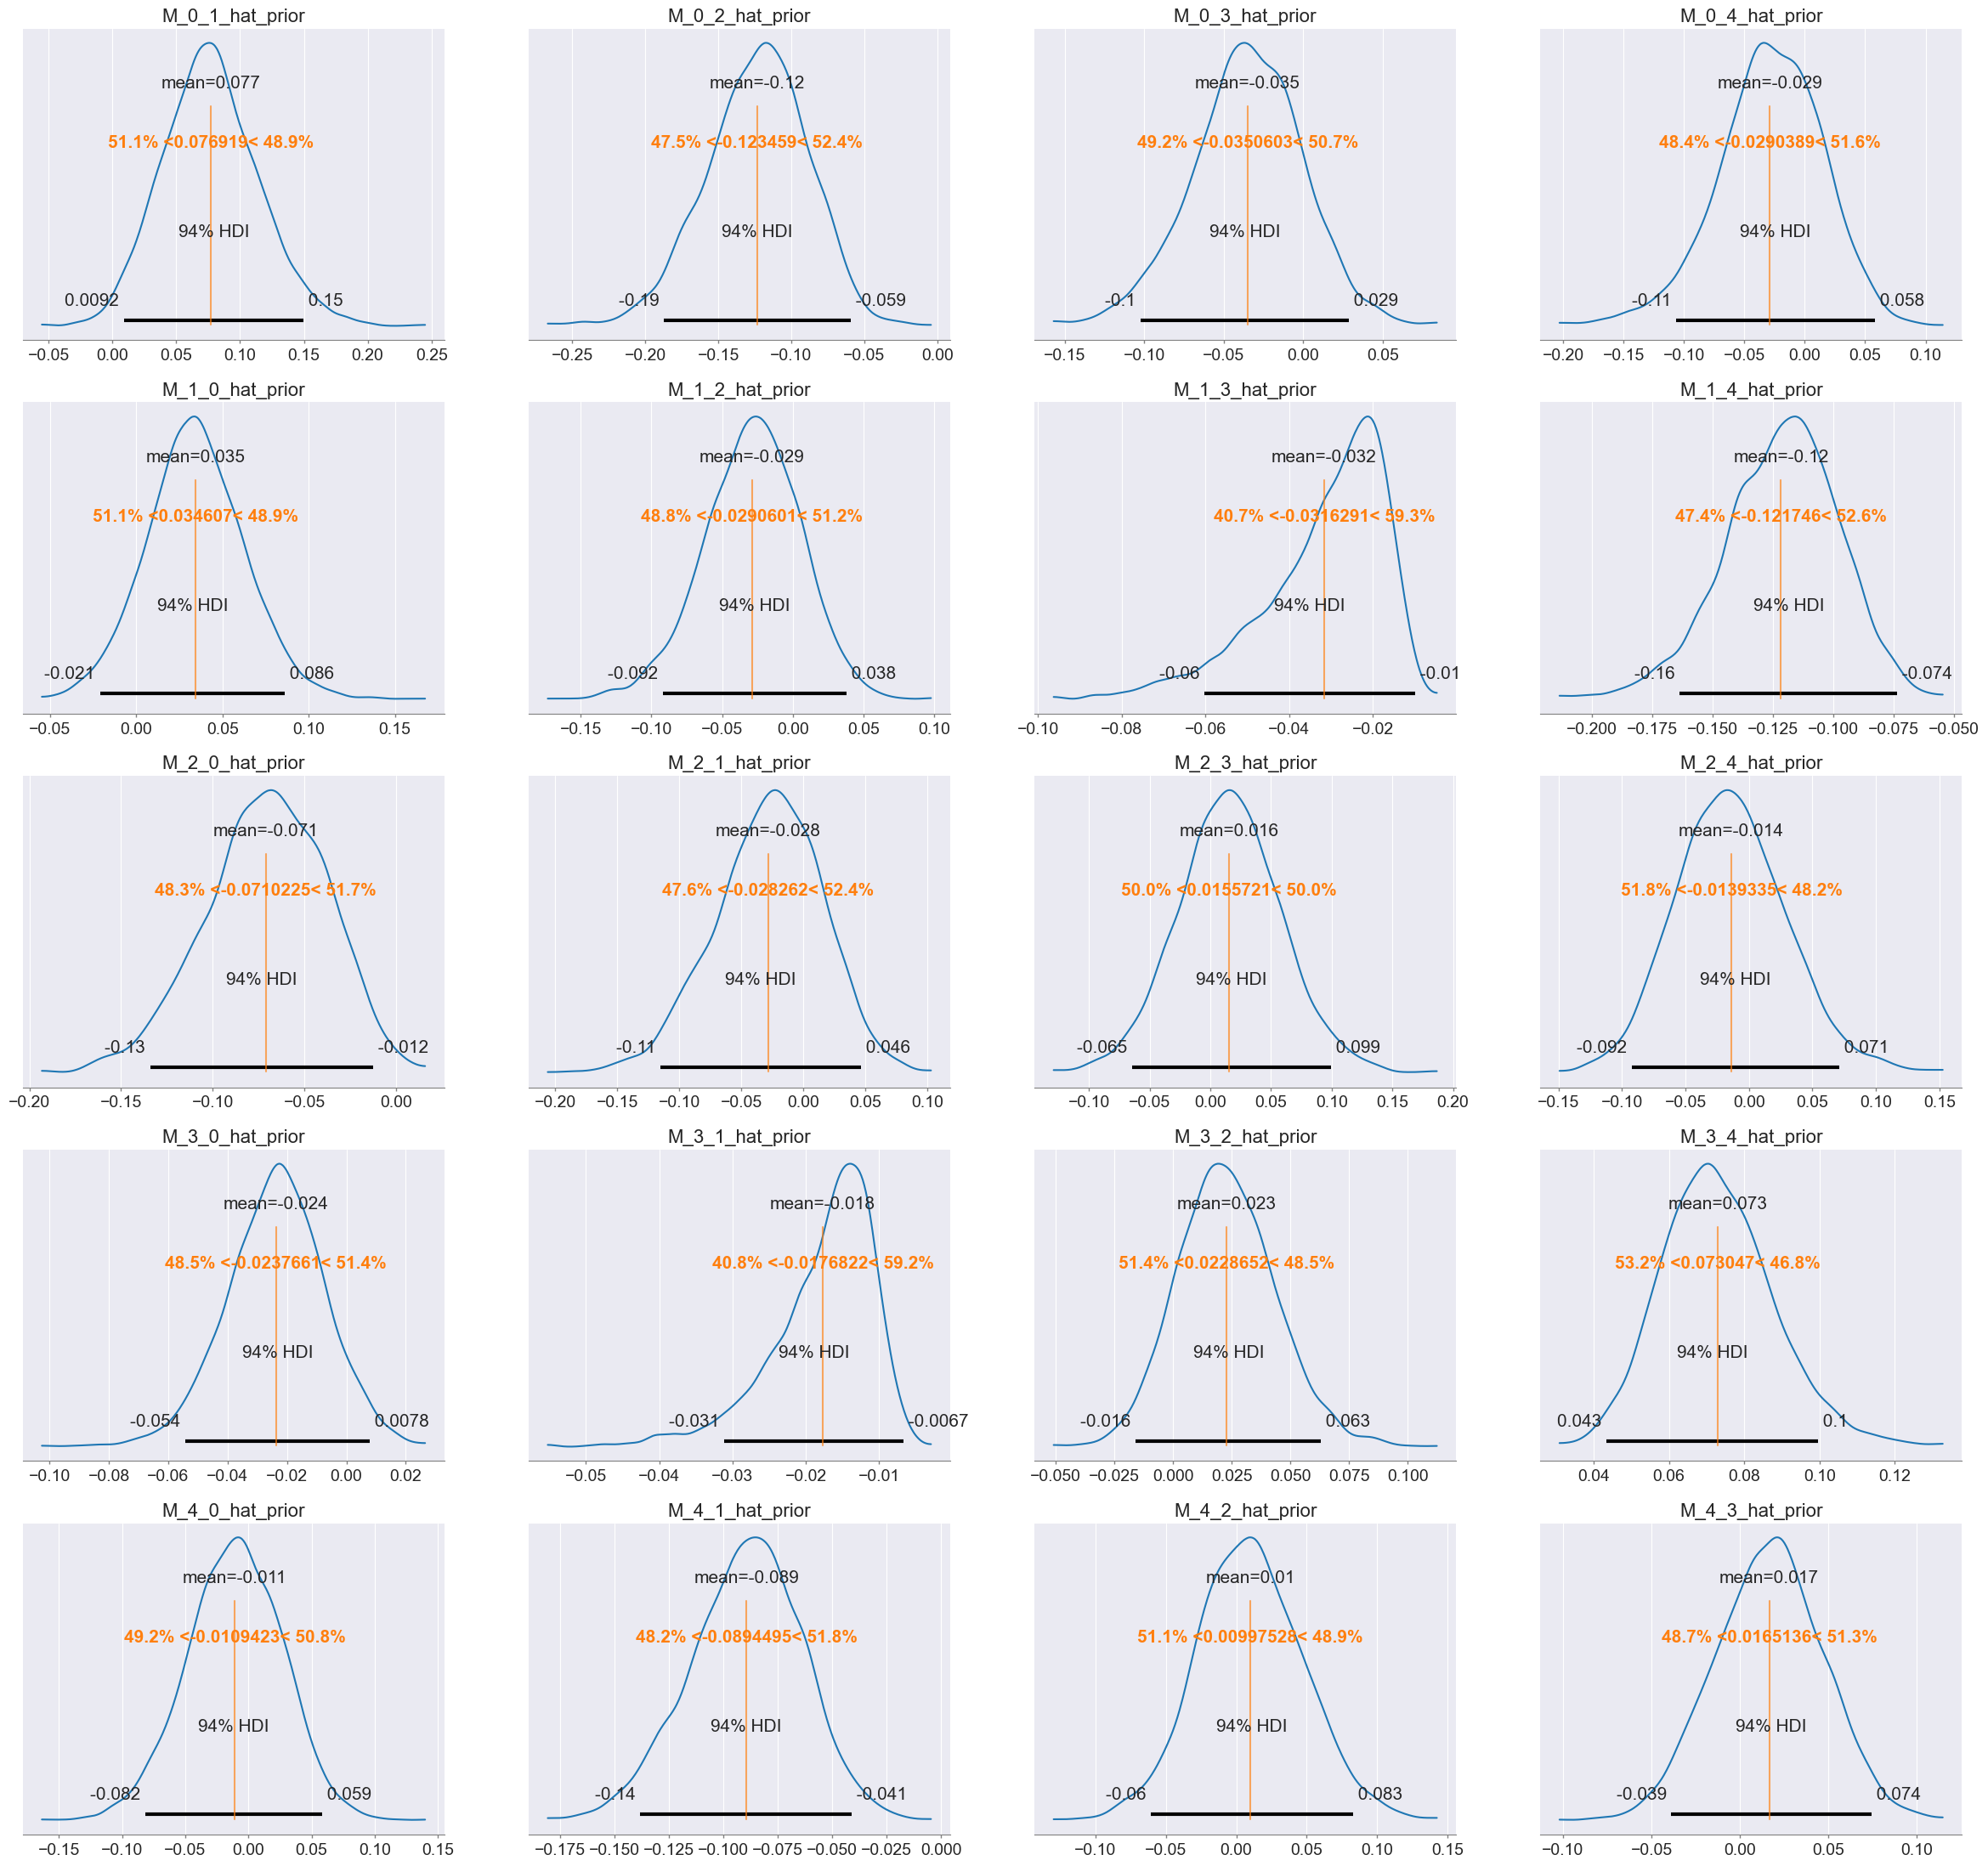

AttributeError: 'TensorVariable' object has no attribute 'tolist'

In [7]:
inference = infergLVbayes(X, F, mu, M, DA=DA, DA0=DA0, N=N, noise_stddev=noise_stddev, epsilon=epsilon)
idata, var_names = inference.run_bayes_gLV_shrinkage_pert()

In [ ]:
# print summary
summary = az.summary(idata, var_names=var_names)
print(summary[["mean", "sd", "r_hat"]])

# Write posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')

In [ ]:
# get posterior medians
M_h = np.median(idata.posterior["M_hat"].values, axis=(0,1))

mu_h = np.median(idata.posterior["mu_hat"].values, axis=(0, 1))
mu_h = mu_h.flatten()

e_h = np.median(idata.posterior["epsilon_hat"].values, axis=(0, 1))
# reshape e_h so it is the same shape as epsilon
e_h = e_h.reshape(epsilon.shape)

# compare median posterior values to true values
compare_params(mu=(mu, mu_h), M=(M, M_h), e=(epsilon, e_h))

#plot_interaction_matrix(M_h)

infer_h = infergLVbayes(M_h)
matrix = infer_h.plot_interaction_matrix(M = M, M_h =M_h)

# Assess fit
predictor = sim_gLV(num_species=num_species,
                    num_perturbations=num_perturbations,
                    M=M_h,
                    mu=mu_h,
                    epsilon=e_h)

print('epsilon:', epsilon)
print('epsilon_h:', e_h)

yobs, init_species, mu, M, _  = simulator.simulate(times=times, init_species=init_species, u=pert_fn)
yobs_h, _, _, _, _ = predictor.simulate(times=times, init_species=init_species, u=pert_fn)
plot_fit_gLV(yobs, yobs_h, times)